<a href="https://colab.research.google.com/github/taravatp/Deep_Learning_Practices/blob/main/DataLoaders/coco_instance_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import all the required libraries

In [ ]:
!pip install -qU torch_snippets
!pip install import_ipynb 
!pip install jsonlines

     |████████████████████████████████| 42 kB 858 kB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 217 kB 49.2 MB/s 
     |████████████████████████████████| 58 kB 4.6 MB/s 
     |████████████████████████████████| 10.9 MB 48.3 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=9d2e78e06ae2ad39849e396eda3ac93c3e3db273538b0fa2d36d7645b46b1bb3
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import torch

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torch_snippets import *

from pycocotools.coco import COCO
from pycocotools import mask

import import_ipynb

#defining the dataset

In [ ]:
class coco_instance_dataset(Dataset):
  def __init__(self,flag='train',transform = None):

    json_stuff = '/content/drive/MyDrive/panoptic_FPN/dataset/annotations/stuff_val2017.json' #stuff annotations
    json_things = '/content/drive/MyDrive/panoptic_FPN/dataset/annotations/instances_val2017.json' #things annotations
    self.root = '/content/drive/MyDrive/panoptic_FPN/dataset/val2017' #path of original images
    
    self.cocoStuff = COCO(json_stuff)
    self.cocoThing = COCO(json_things)
    self.image_IDS = self.get_imageIDS()


    if flag == 'train':
      self.image_IDS = self.image_IDS[0:1500]
      self.images = self.cocoThing.loadImgs(self.image_IDS) #each image is a disctionary
    else: 
      self.image_IDS = self.image_IDS[1500:1700]
      self.images = self.cocoThing.loadImgs(self.image_IDS) #each image is a disctionary

    self.category_IDS = self.cocoThing.getCatIds()
    self.categories = self.cocoThing.loadCats(self.category_IDS)
    
  def get_imageIDS(self):
    image_IDS_stuff = self.cocoStuff.getImgIds() #getting the ID of all images
    image_IDS_stuff = [item for item in image_IDS_stuff if len(self.cocoStuff.getAnnIds(item))!=0] #removing images which do not have any stuff annotations

    image_IDS_things = self.cocoThing.getImgIds() #getting the ID of all images
    image_IDS_things = [item for item in image_IDS_things if len(self.cocoThing.getAnnIds(item))!=0] #removing images which do not have any things annotations

    image_IDS_stuff = set(image_IDS_stuff) #converting list to set
    image_IDS_things = set(image_IDS_things) #converting list to set

    image_IDS = list(image_IDS_stuff.intersection(image_IDS_things)) #finding the intersection
    return image_IDS

  def get_className(self,catIDs):
    category = self.cocoThing.loadCats(catIDs)
    for i in range(len(category)):
      print(category[i]['name'])

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):

    image = self.images[idx]
    imageID =image['id']

    annotation_IDS = self.cocoThing.getAnnIds(imgIds=imageID)
    annotations = self.cocoThing.loadAnns(annotation_IDS)

    image_path = os.path.join(self.root,image['file_name'])
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR) #all images are in BGR format - loads a color image H--W-C
    original_image = original_image.transpose(2,0,1) #(C-H-W)
    original_image = original_image/255 #normalizing
    original_image = torch.as_tensor(original_image, dtype=torch.float) #converting numpy to tensor

    bbox=[]
    areas=[]
    labels=[]
    masks=[]

    for i in range(len(annotations)):
      boxes = annotations[i]['bbox']
      bbox.append([boxes[0],boxes[1],boxes[0]+boxes[2],boxes[1]+boxes[3]])
      areas.append(annotations[i]['area'])
      labels.append(annotations[i]['category_id'])
      masks.append(self.cocoThing.annToMask(annotations[i])) #its a binary mask  
   
    bbox = torch.as_tensor(np.array(bbox), dtype=torch.float32)
    areas = torch.as_tensor(np.array(areas), dtype=torch.float32)
    labels = torch.as_tensor(np.array(labels),dtype=torch.int64)
    masks = torch.as_tensor(np.array(masks),dtype=torch.uint8)
    imageID = torch.tensor(np.array([imageID]))
    
    target = {}
    target['boxes'] = bbox
    target['labels'] = labels
    target['masks'] = masks
    target['image_id'] = imageID
    target['area'] = areas
    
    return original_image,target

#experminet with a sample data and its ground truth annotations

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
loading annotations into memory...
Done (t=1.31s)
creating index...
index created!
airplane
truck
Tensor	Shape: torch.Size([3, 427, 640])	Min: 0.000	Max: 1.000	Mean: 0.564	dtype: torch.float32
Dict Of 5 items
	BOXES:
	Tensor	Shape: torch.Size([2, 4])	Min: 0.000	Max: 519.120	Mean: 171.245	dtype: torch.float32
	LABELS:
	Tensor	Shape: torch.Size([2])	Min: 5.000	Max: 8.000	Mean: 6.500	dtype: torch.int64
	MASKS:
	Tensor	Shape: torch.Size([2, 427, 640])	Min: 0.000	Max: 1.000	Mean: 0.240	dtype: torch.uint8
	IMAGE_ID:
	Tensor	Shape: torch.Size([1])	Min: 272049.000	Max: 272049.000	Mean: 272049.000	dtype: torch.int64
	AREA:
	Tensor	Shape: torch.Size([2])	Min: 9733.885	Max: 121258.867	Mean: 65496.375	dtype: torch.float32


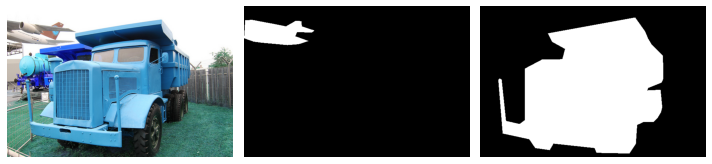

In [ ]:
if __name__ == '__main__':

  test_data = coco_instance_dataset(flag='test')
  image,target = test_data[30]
  test_data.get_className(target['labels'].numpy())
  inspect(image,target)
  subplots([image,*target['masks']],sz=10)